In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.filters.hp_filter import hpfilter


import warnings
warnings.filterwarnings('ignore')

# Adjust pandas display settings
pd.options.display.float_format = '{:.6f}'.format

In [2]:
# Connect to the SQLite3 database
conn = sqlite3.connect('binance_data.db')
cursor = conn.cursor()

# Execute the JOIN query to get the data of ids',pairs and prices
query = """
SELECT 
    currencies.id AS currency_id, 
    currencies.pair, 
    pairs_price.*
FROM 
    pairs_price
JOIN 
    currencies 
ON 
    pairs_price.pair_id = currencies.id;
"""

# Load the query results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert the 'open_time' column from Unix timestamp to human-readable date format
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')

# Set the MultiIndex with currencies.id, currencies.pair
df.set_index(['currency_id', 'pair'], inplace = True)

df.sort_index(level='currency_id', inplace = True)

df


id  pair_id  open_time        open        high  \
currency_id pair                                                          
1           BTCUSDT   68686        1 2017-08-17 4261.480000 4485.390000   
            BTCUSDT   68687        1 2017-08-18 4285.080000 4371.520000   
            BTCUSDT   68688        1 2017-08-19 4108.370000 4184.690000   
            BTCUSDT   68689        1 2017-08-20 4120.980000 4211.080000   
            BTCUSDT   68690        1 2017-08-21 4069.130000 4119.620000   
...                     ...      ...        ...         ...         ...   
382         ZROUSDT  417639      382 2024-07-07    4.201000    4.377000   
            ZROUSDT  417640      382 2024-07-08    4.000000    4.120000   
            ZROUSDT  417641      382 2024-07-09    3.867000    4.072000   
            ZROUSDT  417642      382 2024-07-10    3.867000    4.519000   
            ZROUSDT  417643      382 2024-07-11    4.019000    4.100000   

                            low       close          volume  \
currency_id pair                                              
1           BTCUSDT 4200.740000 4285.080000      795.150377   
            BTCUSDT 3938.770000 4108.370000     1199.888264   
            BTCUSDT 3850.000000 4139.980000      381.309763   
            BTCUSDT 4032.620000 4086.290000      467.083022   
            BTCUSDT 3911.790000 4016.000000      691.743060   
...                         ...         ...             ...   
382         ZROUSDT    3.713000    4.000000 24447217.480000   
            ZROUSDT    3.682000    3.868000 21960978.270000   
            ZROUSDT    3.741000    3.865000 13180168.440000   
            ZROUSDT    3.666000    4.019000 19475418.850000   
            ZROUSDT    3.820000    3.927000  6025541.340000   

                     quote_asset_volume  number_of_trades  \
currency_id pair                                            
1           BTCUSDT      3454770.050732       3427.000000   
            BTCUSDT      5086958.306172       5233.000000   
            BTCUSDT      1549483.735422       2153.000000   
            BTCUSDT      1930364.390326       2321.000000   
            BTCUSDT      2797231.714027       3972.000000   
...                                 ...               ...   
382         ZROUSDT     98103447.662620     320230.000000   
            ZROUSDT     85125041.988560     316652.000000   
            ZROUSDT     51074079.159230     186738.000000   
            ZROUSDT     81452065.636800     264303.000000   
            ZROUSDT     23666532.527780      87180.000000   

                     taker_buy_base_asset_volume  taker_buy_quote_asset_volume  
currency_id pair                                                                
1           BTCUSDT                   616.248541                2678216.400604  
            BTCUSDT                   972.868710                4129123.316518  
            BTCUSDT                   274.336042                1118001.870087  
            BTCUSDT                   376.795947                1557401.333737  
            BTCUSDT                   557.356107                2255662.553158  
...                                          ...                           ...  
382         ZROUSDT              12351461.600000               49588446.141160  
            ZROUSDT              10867181.390000               42108711.519280  
            ZROUSDT               6905082.690000               26766180.283720  
            ZROUSDT               9920741.640000               41533285.609520  
            ZROUSDT               3314811.440000               13017832.724260  

[419604 rows x 12 columns]

In [3]:
# Function to identify missing days in the date range
def identify_missing_days(data: pd.DataFrame) -> pd.DatetimeIndex:
    """
    Identifies missing days in the date range of the 'open_time' column in the given DataFrame.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame with a datetime column 'open_time'.
    
    Returns:
    pd.DatetimeIndex: DatetimeIndex of missing days.
    """
    data["open_time"] = pd.to_datetime(data["open_time"]) 
    date_range = pd.date_range(start=data["open_time"].min(), end=data["open_time"].max())
    missing_days = date_range.difference(data["open_time"])
    return missing_days

# Function to fill missing values with the previous row's value
def fill_missing_values(data: pd.DataFrame, missing_days: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Fills missing values in the DataFrame by forward-filling based on the 'open_time' column.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame with a datetime column 'open_time'.
    missing_days (pd.DatetimeIndex): DatetimeIndex of missing days.
    
    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    filled_data = data.set_index("open_time").reindex(
        pd.date_range(start=data["open_time"].min(), end=data["open_time"].max())
    ).fillna(method="ffill").reset_index()
    filled_data.rename(columns={"index": "open_time"}, inplace=True)
    return filled_data

# Function to process each group and log the number of rows and missing days
def process_and_log(name: tuple, group: pd.DataFrame) -> tuple:
    """
    Processes each group to calculate the number of rows and missing days.
    
    Parameters:
    name (tuple): Name of the group.
    group (pd.DataFrame): Group DataFrame.
    
    Returns:
    tuple: Length of the group, number of missing days.
    """
    missing_days = identify_missing_days(group)
    return len(group), len(missing_days)

# Function to apply group processing and return a summary DataFrame
def apply_group_processing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies group processing to the DataFrame and returns a summary of missing values.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame to be processed.
    
    Returns:
    pd.DataFrame: Summary DataFrame with missing value statistics for each group.
    """
    results = []
    for name, group in df.groupby(["currency_id", "pair"]):
        length, missing_count = process_and_log(name, group)
        percent_missing_dates = (missing_count / length) * 100 if length > 0 else float("nan")
        results.append((name[0], name[1], length, missing_count, percent_missing_dates))
    
    result_df = pd.DataFrame(results, columns=["currency_id", "pair", "length", "missing_count", "missing_%"])
    result_df.set_index(["currency_id", "pair"], inplace=True)
    return result_df

# Call the function to apply group processing
data_cleansing = apply_group_processing(df)

# Sort the result by missing_count
data_cleansing_sorted = data_cleansing.sort_values(by="missing_count", ascending=False)

# Display the result with missing values
print(data_cleansing_sorted[data_cleansing_sorted["missing_count"] > 0])

# Function to fill missing values for groups with less than 1% missing data
def apply_fill_missing(df: pd.DataFrame, cleansing_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fills missing values for groups with less than 1% missing data and returns the filled DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with missing values.
    cleansing_df (pd.DataFrame): DataFrame with missing value statistics for each group.
    
    Returns:
    pd.DataFrame: DataFrame with missing values filled for groups with less than 1% missing data.
    """
    filled_groups = []
    for name, group in df.groupby(["currency_id", "pair"]):
        if (name in cleansing_df.index) and (cleansing_df.loc[name, "missing_%"] < 1):
            missing_days = identify_missing_days(group)
            group = fill_missing_values(group, missing_days)
            group["currency_id"] = name[0]
            group["pair"] = name[1]
        filled_groups.append(group)
    
    filled_df = pd.concat(filled_groups).reset_index(drop=True)
    filled_df.set_index(["currency_id", "pair", "open_time"], inplace=True)
    return filled_df

# Filter out symbols with more than 1% missing values
filtered_data_cleansing_sorted = data_cleansing_sorted[data_cleansing_sorted["missing_%"] < 1]

# Apply the function to fill missing values
filled_data = apply_fill_missing(df, filtered_data_cleansing_sorted)

filled_data


                       length  missing_count  missing_%
currency_id pair                                       
67          FTTUSDT      1356            310  22.861357
10          TUSDUSDT     2069            165   7.974867
217         USDPUSDT      871            165  18.943743
19          USDCUSDT     1871            165   8.818813
50          CVCUSDT      1628            153   9.398034
46          KEYUSDT      1754             27   1.539339
108         LUNAUSDT     1404             17   1.210826
216         VIDTUSDT     1029              8   0.777454
139         STRAXUSDT    1325              7   0.528302
235         BNXUSDT       976              5   0.512295
123         SUNUSDT      1387              3   0.216294
205         QUICKUSDT    1061              3   0.282752
346         AEURUSDT      219              2   0.913242


id    pair_id        open  \
currency_id pair    open_time                                         
1.000000    BTCUSDT 2017-08-17  68686.000000   1.000000 4261.480000   
                    2017-08-18  68687.000000   1.000000 4285.080000   
                    2017-08-19  68688.000000   1.000000 4108.370000   
                    2017-08-20  68689.000000   1.000000 4120.980000   
                    2017-08-21  68690.000000   1.000000 4069.130000   
...                                      ...        ...         ...   
382.000000  ZROUSDT 2024-07-07 417639.000000 382.000000    4.201000   
                    2024-07-08 417640.000000 382.000000    4.000000   
                    2024-07-09 417641.000000 382.000000    3.867000   
                    2024-07-10 417642.000000 382.000000    3.867000   
                    2024-07-11 417643.000000 382.000000    4.019000   

                                      high         low       close  \
currency_id pair    open_time                                        
1.000000    BTCUSDT 2017-08-17 4485.390000 4200.740000 4285.080000   
                    2017-08-18 4371.520000 3938.770000 4108.370000   
                    2017-08-19 4184.690000 3850.000000 4139.980000   
                    2017-08-20 4211.080000 4032.620000 4086.290000   
                    2017-08-21 4119.620000 3911.790000 4016.000000   
...                                    ...         ...         ...   
382.000000  ZROUSDT 2024-07-07    4.377000    3.713000    4.000000   
                    2024-07-08    4.120000    3.682000    3.868000   
                    2024-07-09    4.072000    3.741000    3.865000   
                    2024-07-10    4.519000    3.666000    4.019000   
                    2024-07-11    4.100000    3.820000    3.927000   

                                        volume  quote_asset_volume  \
currency_id pair    open_time                                        
1.000000    BTCUSDT 2017-08-17      795.150377      3454770.050732   
                    2017-08-18     1199.888264      5086958.306172   
                    2017-08-19      381.309763      1549483.735422   
                    2017-08-20      467.083022      1930364.390326   
                    2017-08-21      691.743060      2797231.714027   
...                                        ...                 ...   
382.000000  ZROUSDT 2024-07-07 24447217.480000     98103447.662620   
                    2024-07-08 21960978.270000     85125041.988560   
                    2024-07-09 13180168.440000     51074079.159230   
                    2024-07-10 19475418.850000     81452065.636800   
                    2024-07-11  6025541.340000     23666532.527780   

                                number_of_trades  taker_buy_base_asset_volume  \
currency_id pair    open_time                                                   
1.000000    BTCUSDT 2017-08-17       3427.000000                   616.248541   
                    2017-08-18       5233.000000                   972.868710   
                    2017-08-19       2153.000000                   274.336042   
                    2017-08-20       2321.000000                   376.795947   
                    2017-08-21       3972.000000                   557.356107   
...                                          ...                          ...   
382.000000  ZROUSDT 2024-07-07     320230.000000              12351461.600000   
                    2024-07-08     316652.000000              10867181.390000   
                    2024-07-09     186738.000000               6905082.690000   
                    2024-07-10     264303.000000               9920741.640000   
                    2024-07-11      87180.000000               3314811.440000   

                                taker_buy_quote_asset_volume  
currency_id pair    open_time                                 
1.000000    BTCUSDT 2017-08-17                2678216.400604  
                    2017-08-18                4129123

In [4]:
filled_data.describe()

,id,pair_id,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000
mean,209807.030808,134.870394,283.366696,292.198843,274.057022,283.562655,79184732141.966171,38433161.677937,75147.835406,39374854258.991409,19086224.673315
std,121131.583597,94.081727,3061.505265,3151.928021,2965.622852,3063.729275,2041321007357.600342,251450782.201453,295994.423135,1033334149584.215454,125106801.584424
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.553260,482.811452,11.000000,0.316520,318.116636
25%,104901.750000,53.000000,0.086100,0.090215,0.082430,0.086100,1134053.417175,1098741.627949,7556.000000,544599.800000,525605.446500
50%,209809.500000,122.000000,0.538000,0.567600,0.512100,0.537900,6981622.300000,3506906.525044,20024.000000,3369811.125000,1701734.148631
75%,314714.250000,207.000000,3.510250,3.709000,3.335200,3.508000,44985288.637500,13581637.327357,55046.250000,21924163.000000,6708850.209808
max,419604.000000,382.000000,82875.440000,95000.000000,71333.310000,82885.120000,254270289671127.000000,17598561857.084930,15920580.000000,133050653421907.000000,9013969074.852932


In [5]:
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 419632 entries, (1.0, 'BTCUSDT', Timestamp('2017-08-17 00:00:00')) to (382.0, 'ZROUSDT', Timestamp('2024-07-11 00:00:00'))
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            419632 non-null  float64
 1   pair_id                       419632 non-null  float64
 2   open                          419632 non-null  float64
 3   high                          419632 non-null  float64
 4   low                           419632 non-null  float64
 5   close                         419632 non-null  float64
 6   volume                        419632 non-null  float64
 7   quote_asset_volume            419632 non-null  float64
 8   number_of_trades              419632 non-null  float64
 9   taker_buy_base_asset_volume   419632 non-null  float64
 10  taker_buy_quote_asset_volume  419632 non-null  float64
dtypes: float6

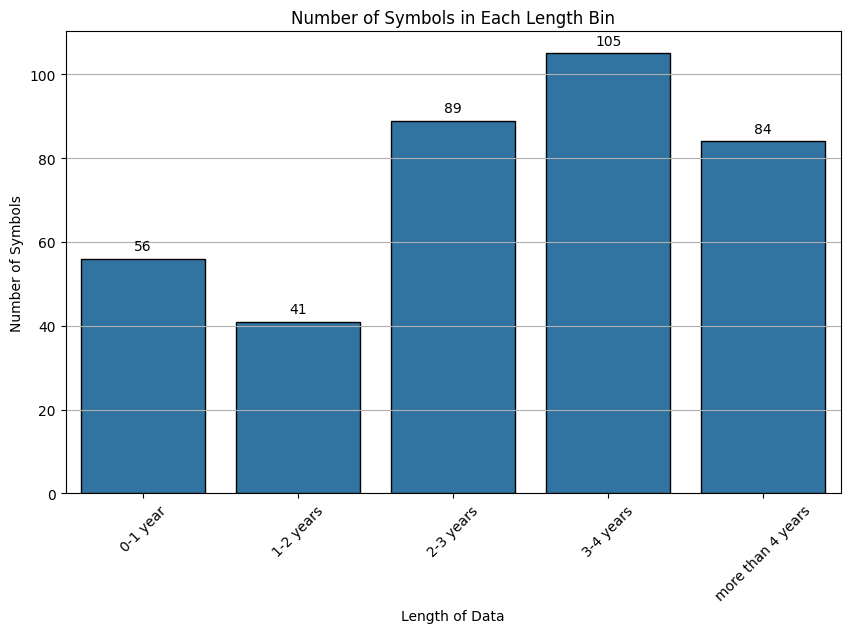

In [6]:
# Convert the result to a DataFrame for better readability
group_lengths_df = filled_data.reset_index().groupby(["currency_id", "pair"]).size().reset_index(name="length")

# Define bins for the specified periods in days
bins = [0, 365, 2*365, 3*365, 4*365, float('inf')]
labels = ["0-1 year", "1-2 years", "2-3 years", "3-4 years", "more than 4 years"]

# Bin the lengths into the specified intervals
group_lengths_df["length_bin"] = pd.cut(group_lengths_df["length"], bins=bins, labels=labels, right=False)

# Count the number of tickers in each bin
bin_counts = group_lengths_df["length_bin"].value_counts().sort_index()

# Convert bin_counts to DataFrame for seaborn plotting
bin_counts_df = bin_counts.reset_index()
bin_counts_df.columns = ["Length Bin", "Number of Symbols"]

# Plot the counts for each bin using seaborn
def plot_length_bins(bin_counts_df: pd.DataFrame) -> None:
    """
    Plots the counts of symbols in each length bin.
    
    Parameters:
    bin_counts_df (pd.DataFrame): DataFrame containing length bins and counts of symbols.
    """
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x="Length Bin", y="Number of Symbols", data=bin_counts_df, edgecolor="black")

    # Annotate the bars with the number of values
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = "center", va = "center", 
                         xytext = (0, 9), 
                         textcoords = "offset points")

    plt.xlabel('Length of Data')
    plt.ylabel('Number of Symbols')
    plt.title('Number of Symbols in Each Length Bin')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Call the function to plot the data
plot_length_bins(bin_counts_df)

In [7]:
# Filter pairs with length greater than 365 days
def filter_long_pairs(group_lengths_df: pd.DataFrame, threshold: int = 365) -> pd.Index:
    """
    Filters pairs with length greater than the given threshold.
    
    Parameters:
    group_lengths_df (pd.DataFrame): DataFrame containing the length of each group.
    threshold (int): Minimum length to filter pairs.
    
    Returns:
    pd.Index: Index of pairs with length greater than the threshold.
    """
    return group_lengths_df[group_lengths_df["length"] > threshold].set_index(["currency_id", "pair"]).index

# Create a boolean mask to filter the original dataframe
def create_filter_mask(filled_data: pd.DataFrame, long_pairs: pd.Index) -> pd.Series:
    """
    Creates a boolean mask to filter the original dataframe for pairs longer than the threshold.
    
    Parameters:
    filled_data (pd.DataFrame): The original filled dataframe.
    long_pairs (pd.Index): Index of pairs with length greater than the threshold.
    
    Returns:
    pd.Series: Boolean mask for filtering the original dataframe.
    """
    currency_mask = filled_data.index.get_level_values("currency_id").isin(long_pairs.get_level_values("currency_id"))
    pair_mask = filled_data.index.get_level_values("pair").isin(long_pairs.get_level_values("pair"))
    return currency_mask & pair_mask

# Filter pairs with length greater than 365 days
long_pairs = filter_long_pairs(group_lengths_df)

# Create a boolean mask to filter the original dataframe
mask = create_filter_mask(filled_data, long_pairs)

# Apply the mask to get the filtered dataframe
filtered_df = filled_data[mask]

In [8]:
# Function to calculate daily returns and cumulative returns
def calculate_return(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the daily percentage change and cumulative returns for the given DataFrame.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame with a 'close' column.
    
    Returns:
    pd.DataFrame: DataFrame with added columns for daily percentage change and cumulative returns.
    """
    # Calculate daily percentage change
    data["daily_change_%"] = data["close"].pct_change()
    
    # Calculate cumulative returns
    data["returns"] = ((1 + data["daily_change_%"]).cumprod() - 1).shift(-1)
    
    return data

def apply_calculate_return(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the calculate_return function to each group in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: DataFrame with calculated returns for each group.
    """
    df.reset_index(level = "open_time", inplace = True)
    calculated_returns = []
    for name, group in df.groupby(["currency_id", "pair"]):
        returns = calculate_return(group)
        group["currency_id"] = name[0]
        group["pair"] = name[1]
        calculated_returns.append(group)
    
    filtered_df_with_returns = pd.concat(calculated_returns).reset_index(drop=True)
    filtered_df_with_returns.set_index(["currency_id", "pair", "open_time"], inplace=True)
    return filtered_df_with_returns
    
# Apply the calculate_return function to the filtered dataframe
filtered_df_with_returns = apply_calculate_return(filtered_df)

In [9]:
filtered_df_with_returns

id    pair_id        open  \
currency_id pair       open_time                                         
1.000000    BTCUSDT    2017-08-17  68686.000000   1.000000 4261.480000   
                       2017-08-18  68687.000000   1.000000 4285.080000   
                       2017-08-19  68688.000000   1.000000 4108.370000   
                       2017-08-20  68689.000000   1.000000 4120.980000   
                       2017-08-21  68690.000000   1.000000 4069.130000   
...                                         ...        ...         ...   
326.000000  PENDLEUSDT 2024-07-07 282346.000000 326.000000    4.006000   
                       2024-07-08 282347.000000 326.000000    3.594000   
                       2024-07-09 282348.000000 326.000000    3.338000   
                       2024-07-10 282349.000000 326.000000    3.474000   
                       2024-07-11 282350.000000 326.000000    3.629000   

                                         high         low       close  \
currency_id pair       open_time                                        
1.000000    BTCUSDT    2017-08-17 4485.390000 4200.740000 4285.080000   
                       2017-08-18 4371.520000 3938.770000 4108.370000   
                       2017-08-19 4184.690000 3850.000000 4139.980000   
                       2017-08-20 4211.080000 4032.620000 4086.290000   
                       2017-08-21 4119.620000 3911.790000 4016.000000   
...                                       ...         ...         ...   
326.000000  PENDLEUSDT 2024-07-07    4.013000    3.581000    3.596000   
                       2024-07-08    3.747000    3.320000    3.339000   
                       2024-07-09    3.538000    3.298000    3.476000   
                       2024-07-10    3.776000    3.407000    3.628000   
                       2024-07-11    3.728000    3.536000    3.713000   

                                           volume  quote_asset_volume  \
currency_id pair       open_time                                        
1.000000    BTCUSDT    2017-08-17      795.150377      3454770.050732   
                       2017-08-18     1199.888264      5086958.306172   
                       2017-08-19      381.309763      1549483.735422   
                       2017-08-20      467.083022      1930364.390326   
                       2017-08-21      691.743060      2797231.714027   
...                                           ...                 ...   
326.000000  PENDLEUSDT 2024-07-07  5117665.700000     19539147.978900   
                       2024-07-08 10942975.100000     38140325.861300   
                       2024-07-09  5706463.800000     19547207.367600   
                       2024-07-10  6033002.300000     21927769.423300   
                       2024-07-11  1554268.300000      5674252.349400   

                                   number_of_trades  \
currency_id pair       open_time                      
1.000000    BTCUSDT    2017-08-17       3427.000000   
                       2017-08-18       5233.000000   
                       2017-08-19       2153.000000   
                       2017-08-20       2321.000000   
                       2017-08-21       3972.000000   
...                                             ...   
326.000000  PENDLEUSDT 2024-07-07     103854.000000   
                       2024-07-08     209556.000000   
                       2024-07-09     111424.000000   
                       2024-07-10     118784.000000   
                       2024-07-11      42940.000000   

                                   taker_buy_base_asset_volume  \
currency_id pair       open_time                                 
1.000000    BTCUSDT    2017-08-17                   616.248541   
                       2017-08-18                   972.868710   
                       2017-08-19                   274.336042   
                       2017-08-20                   376.795947   
                       2017-08-21                   557.356107   
... 

In [10]:
# Create separate dataset for Explratory data analysis operations
eda_data = filtered_df_with_returns.reset_index()

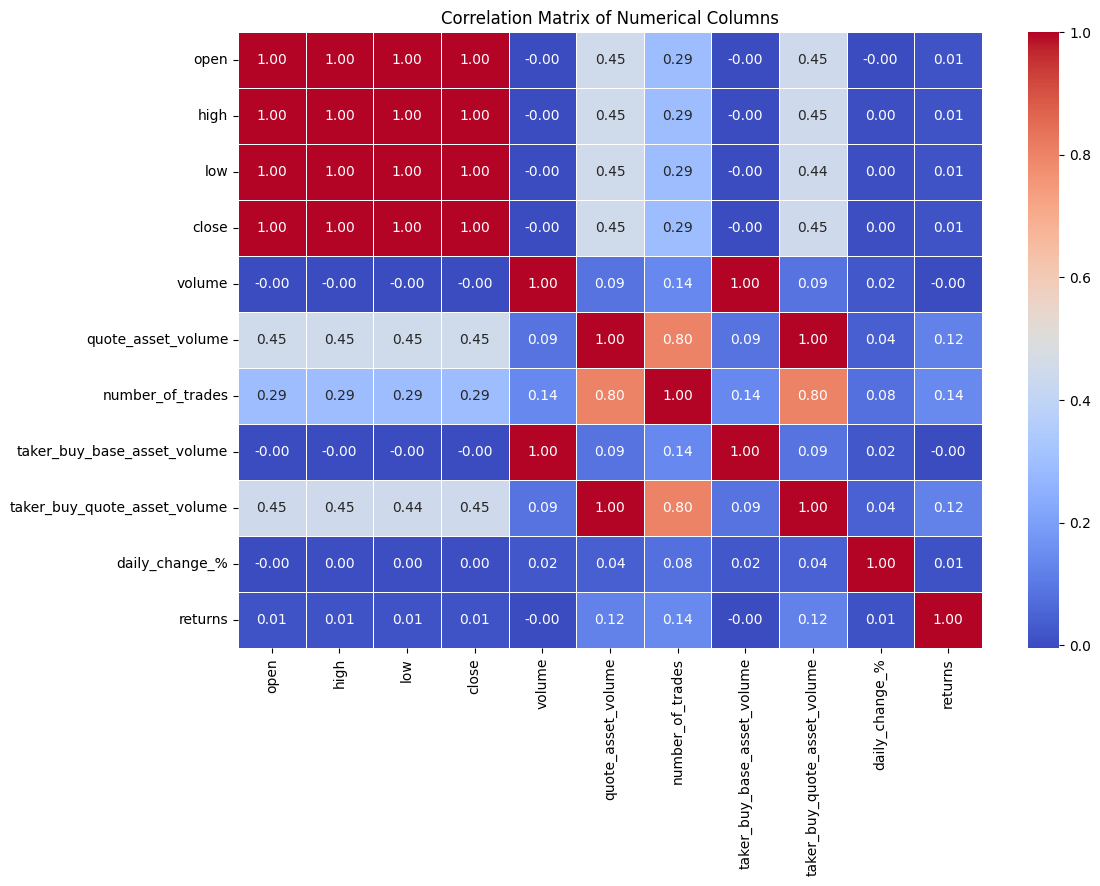

In [11]:
# Identify numericacl columns
numerical_columns = eda_data.columns[5:]

# Correlation analysis between numerical columns
correlation_matrix = eda_data[numerical_columns].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [12]:
from scipy.stats import shapiro, anderson

# Function to identify if the distribution of a column is normal using Shapiro-Wilk and Anderson-Darling tests
def identify_distribution(data, column):
    results = {}
    # Perform Shapiro-Wilk test
    stat, p = shapiro(data[column])
    results["shapiro"] = p > 0.05  # Normal if p > 0.05
    
    # Perform Anderson-Darling test
    result = anderson(data[column])
    results["anderson"] = result.statistic < result.critical_values[2]  # Normal if statistic < critical value at 5% level
    
    return results

# Get the unique combinations of currency_id and pair
unique_pairs = eda_data[["currency_id", "pair"]].drop_duplicates()
columns_to_test = numerical_columns

# Initialize the results DataFrame with the correct multi-index
index = pd.MultiIndex.from_frame(unique_pairs)
results_df = pd.DataFrame(index=index, columns=pd.MultiIndex.from_product([columns_to_test, ["shapiro", "anderson"]], names=["column", "test"]))

# Function to apply normality tests and log results
def process_and_log(name, group):
    for column in columns_to_test:
        if column in group.columns:
            test_results = identify_distribution(group, column)
            results_df.loc[name, (column, 'shapiro')] = test_results['shapiro']
            results_df.loc[name, (column, 'anderson')] = test_results['anderson']
        else:
            results_df.loc[name, (column, 'shapiro')] = None
            results_df.loc[name, (column, 'anderson')] = None

# Apply the function to each group
for name, group in eda_data.groupby(['currency_id', 'pair']):
    process_and_log(name, group)

# Fill NaN values with False for pairs that do not have data in columns_to_test
results_df = results_df.fillna(False)

# Print the resulting DataFrame
results_df.sum()

column                        test    
open                          shapiro     0
                              anderson    0
high                          shapiro     0
                              anderson    0
low                           shapiro     0
                              anderson    0
close                         shapiro     0
                              anderson    0
volume                        shapiro     0
                              anderson    0
quote_asset_volume            shapiro     0
                              anderson    0
number_of_trades              shapiro     0
                              anderson    0
taker_buy_base_asset_volume   shapiro     0
                              anderson    0
taker_buy_quote_asset_volume  shapiro     0
                              anderson    0
daily_change_%                shapiro     0
                              anderson    0
returns                       shapiro     0
                              anderso

In [13]:
## Create Multiindex to plot distribution of valeus for pairs and respective columns
eda_data.set_index(['currency_id', 'pair'], inplace = True)

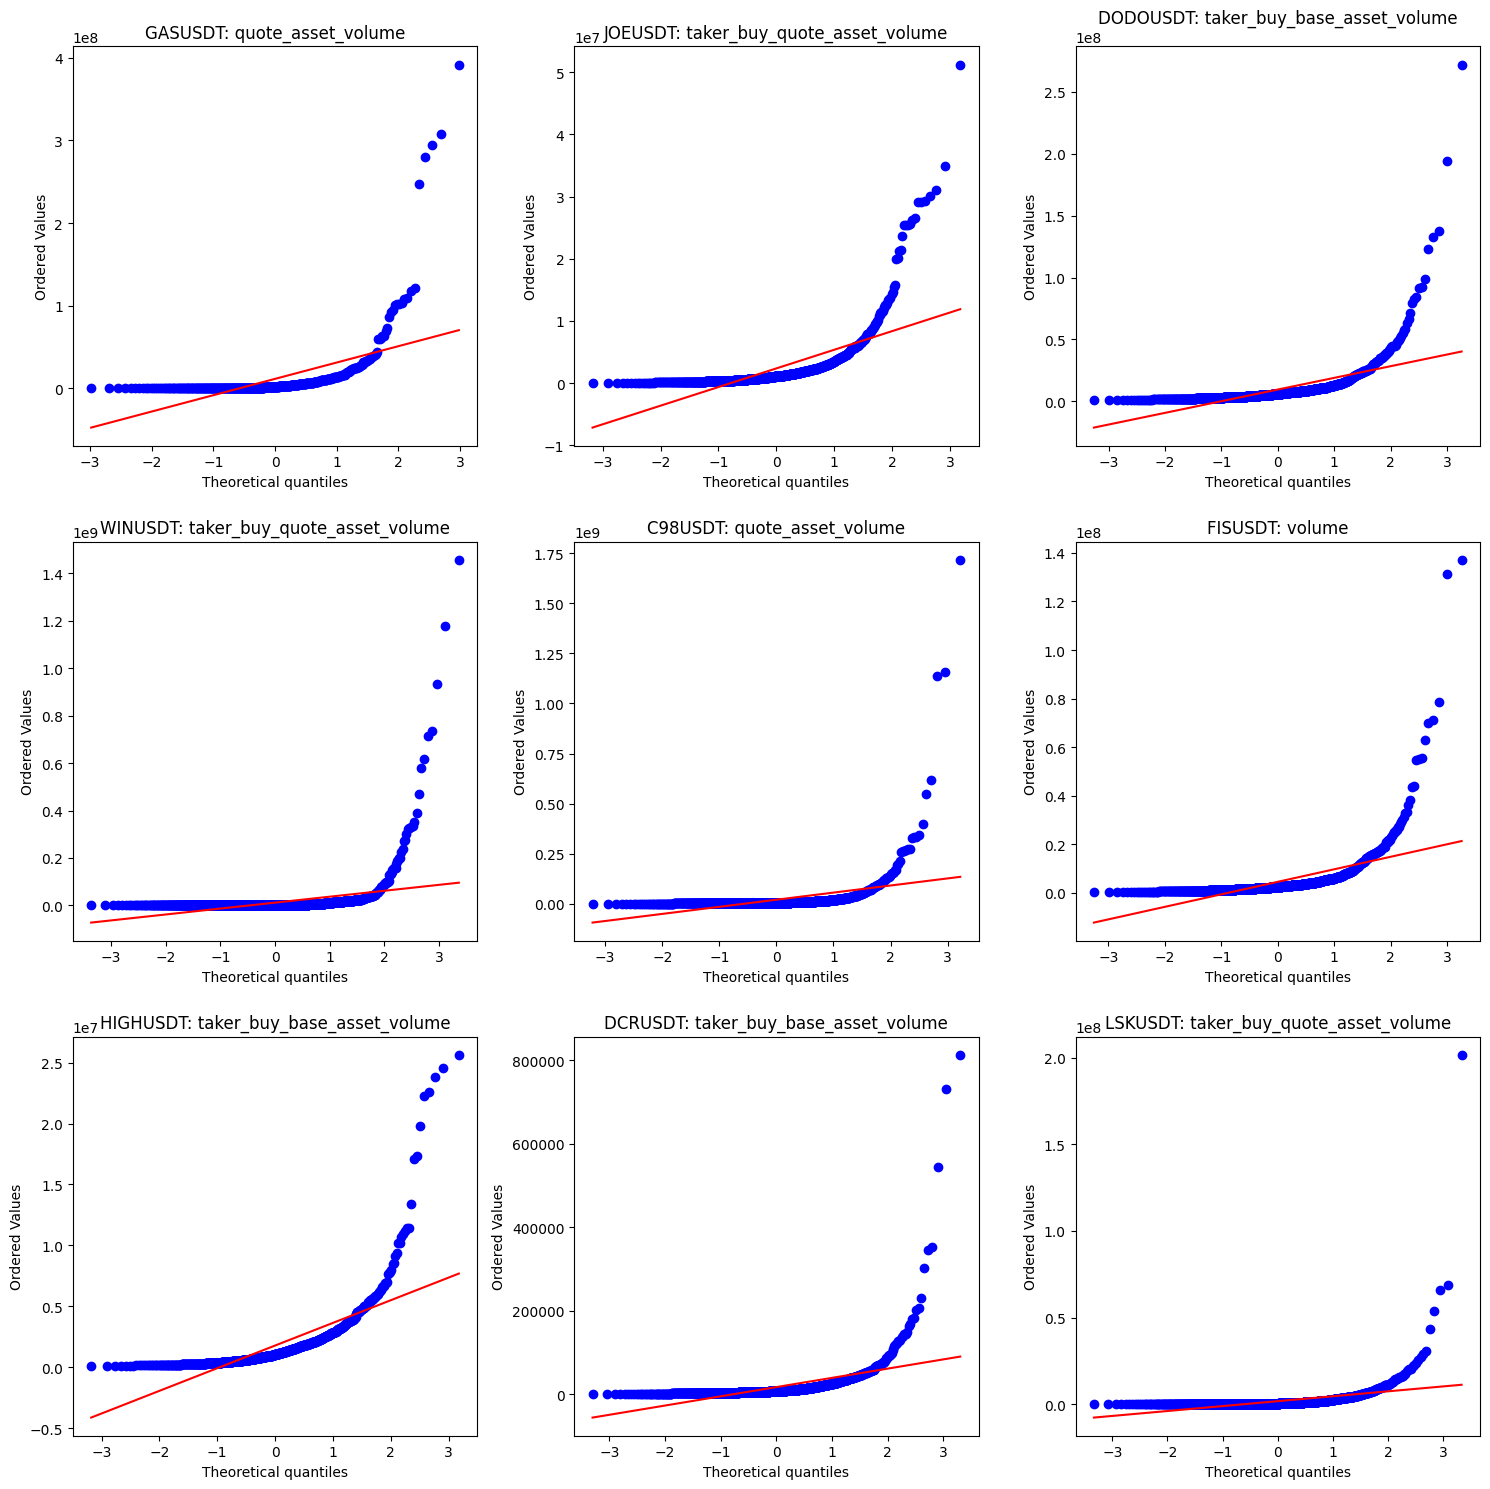

In [14]:
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import pandas as pd

# Columns to test
columns_to_test = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]

# Function to plot random distribution charts
def random_distribution_plots(data: pd.DataFrame, n_plots: int = 6, rows: int = 2) -> None:
    """
    Plots random distribution charts (Q-Q plots) for random tickers and columns within subplots.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame containing data to plot.
    n_plots (int): Total number of plots.
    rows (int): Number of rows in the subplot grid.
    
    Returns:
    None
    """
    cols = n_plots // rows
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axs = axs.flatten()
    
    unique_groups = data.groupby(['currency_id', 'pair']).size().index.tolist()
    
    for i in range(n_plots):
        # Get a random group (currency_id, pair) and a random column
        random_group = random.choice(unique_groups)
        random_column = random.choice(columns_to_test)
        
        # Extract the data series for the random column within the group
        series_to_plot = data.xs(random_group, level=['currency_id', 'pair'])[random_column]
        
        # Plot the Q-Q plot
        stats.probplot(series_to_plot, dist="norm", plot=axs[i])
        symbol_name = f"{random_group[1]}: {random_column}"
        axs[i].set_title(symbol_name)
    
    plt.tight_layout()
    plt.show()

# Assuming eda_data is your DataFrame
random_distribution_plots(eda_data, n_plots=9, rows=3)


In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

# Initialize a list to store the log information
log_info = []

# Function to identify outliers using DBSCAN and replace them with the average of the previous 15 days
def identify_replace_outliers_dbscan(group, column, group_name):
    # Scale the data
    scaler = StandardScaler()
    group_scaled = scaler.fit_transform(group[[column]])
    
    # Apply DBSCAN to detect outliers
    dbscan = DBSCAN(eps=1, min_samples=5)
    group['is_outlier_dbscan'] = dbscan.fit_predict(group_scaled) == -1
    
    # Replace outliers with the average of the previous 15 days
    outliers_count = group['is_outlier_dbscan'].sum()
    log_info.append({
        'group': group_name,
        'column': column,
        'outliers_count': outliers_count,
        'method': 'dbscan'
    })
    
    group.loc[group['is_outlier_dbscan'], column] = group[column].rolling(window=30, min_periods=1).mean()
    
    # Drop the temporary columns
    group = group.drop(columns=['is_outlier_dbscan'])
    
    return group

# Function to apply Box-Cox transformation and then check for outliers using Z-score
def identify_replace_outliers_boxcox(group, column, group_name):
    # Apply Box-Cox transformation
    group['transformed'], _ = boxcox(group[column] + 1)  # Box-Cox requires positive data
    group['z_score'] = (group['transformed'] - group['transformed'].mean()) / group['transformed'].std()
    z_score_threshold = 3
    group[f'is_outlier_boxcox_{column}'] = np.abs(group['z_score']) > z_score_threshold
    
    # Replace outliers with the average of the previous 15 days
    outliers_count = group[f'is_outlier_boxcox_{column}'].sum()
    log_info.append({
        'group': group_name,
        'column': column,
        'outliers_count': outliers_count,
        'method': 'boxcox'
    })
    
    group.loc[group[f'is_outlier_boxcox_{column}'], column] = group[column].rolling(window=30, min_periods=1).mean()
    
    # Drop the temporary columns
    group = group.drop(columns=['transformed', 'z_score', f'is_outlier_boxcox_{column}'])
    
    return group

# Function to perform a second check for outliers using DBSCAN and Box-Cox after replacement
def second_check_outliers(group, column, method):
    if method == 'dbscan':
        # Scale the data
        scaler = StandardScaler()
        group_scaled = scaler.fit_transform(group[[column]])
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=1, min_samples=5)
        group['is_outlier_dbscan_second'] = dbscan.fit_predict(group_scaled) == -1
        second_outliers_count = group['is_outlier_dbscan_second'].sum()
        group = group.drop(columns=['is_outlier_dbscan_second'])
    elif method == 'boxcox':
        group['transformed'], _ = boxcox(group[column] + 1)  # Box-Cox requires positive data
        group['z_score'] = (group['transformed'] - group['transformed'].mean()) / group['transformed'].std()
        z_score_threshold = 3
        group[f'is_outlier_boxcox_{column}_second'] = np.abs(group['z_score']) > z_score_threshold
        second_outliers_count = group[f'is_outlier_boxcox_{column}_second'].sum()
        group = group.drop(columns=['transformed', 'z_score', f'is_outlier_boxcox_{column}_second'])
    
    return second_outliers_count

# Function to process tickers separately
def process_and_log(name, group):
    columns_to_test = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]
    
    for column in columns_to_test:
        if column in group.columns:
            # First, apply DBSCAN method
            group = identify_replace_outliers_dbscan(group, column, name)
            second_outliers_count_dbscan = second_check_outliers(group, column, 'dbscan')
            
            # Then, apply Box-Cox method
            group = identify_replace_outliers_boxcox(group, column, name)
            second_outliers_count_boxcox = second_check_outliers(group, column, 'boxcox')
            
            # Append second check info to log
            log_info[-2]['second_check_outliers'] = second_outliers_count_dbscan
            log_info[-1]['second_check_outliers'] = second_outliers_count_boxcox
    
    return group

# Apply the function to each group
processed_groups = []
for name, group in filtered_df_with_returns.groupby(['currency_id', 'pair']):
    processed_group = process_and_log(name, group)
    processed_groups.append(processed_group)

# Concatenate all processed groups back into a single DataFrame
processed_data = pd.concat(processed_groups)

# Create a DataFrame from the log information
log_df = pd.DataFrame(log_info)

# Display the log DataFrame and the updated dataset
log_df.head(10)

,group,column,outliers_count,method,second_check_outliers
0,"(1.0, BTCUSDT)",volume,0,dbscan,0
1,"(1.0, BTCUSDT)",volume,19,boxcox,1
2,"(1.0, BTCUSDT)",quote_asset_volume,0,dbscan,0
3,"(1.0, BTCUSDT)",quote_asset_volume,0,boxcox,0
4,"(1.0, BTCUSDT)",number_of_trades,0,dbscan,0
5,"(1.0, BTCUSDT)",number_of_trades,1,boxcox,0
6,"(1.0, BTCUSDT)",taker_buy_base_asset_volume,0,dbscan,0
7,"(1.0, BTCUSDT)",taker_buy_base_asset_volume,23,boxcox,1
8,"(1.0, BTCUSDT)",taker_buy_quote_asset_volume,0,dbscan,0
9,"(1.0, BTCUSDT)",taker_buy_quote_asset_volume,1,boxcox,0


In [16]:
processed_data = processed_data.iloc[:, :13]

In [17]:
# Create Simple Moving Averages for Close price
sma_list = [x for x in range(10, 370, 10)]

# Function to process each timeseries
def process_timeseries(data):
    # Create SMAs
    for sma in sma_list:
        data[f"sma_{sma}"] = np.nan
        data[f"sma_{sma}"] = data['close'].rolling(window=sma).mean()

    # Create columns for percent difference between "close" and SMAs
    for movings in data.columns:
        if movings.startswith("sma"):
            column_name = f'price_diff_from_{movings}'
            moving_num = int(movings.split("_")[1])
            data[column_name] = (data["close"] - data[movings]) / data[movings] * moving_num

    # Create volume indicators
    # Average trade size relative
    data["avg_trade_size_in_quote_asset"] = (data['volume'] / data['number_of_trades']) * (data['quote_asset_volume'] / data['volume'])


    data["avg_trade_size_rel"] = (data['volume'] / data['number_of_trades']) / data['volume']

    # Trade intensity relative
    data["trade_intensity"] = data['number_of_trades'] / data['volume']
    
    # Normalize trade intensity
    rolling_window = 30  # Example rolling window size
    data['trade_intensity_mean'] = data['trade_intensity'].rolling(window=rolling_window).mean()
    data['trade_intensity_std'] = data['trade_intensity'].rolling(window=rolling_window).std()
    data['trade_intensity_rel'] = (data['trade_intensity'] - data['trade_intensity_mean']) / data['trade_intensity_std']

    # Calculate Taker Buy Ratio
    taker_buy_ratio = data['taker_buy_base_asset_volume'] / data['volume']

    # Calculate Taker Sell Ratio
    taker_sell_ratio = (data['volume'] - data['taker_buy_base_asset_volume']) / data['volume']
    
    # Calculate Taker Buy to Taker Sell Ratio
    data['taker_buy_to_sell_ratio'] = taker_buy_ratio / taker_sell_ratio

    # Drop intermediate columns
    data.drop(columns=["trade_intensity","trade_intensity_mean", "trade_intensity_std"], inplace=True)

    # Drop rows with NaNs which appeared from creating SMAs
    data = data.dropna()

    # Scale price difference columns with StandardScaler
    scaler_price_diff = StandardScaler()
    columns_to_scale_price_diff = [col for col in data.columns if col.startswith('price_diff_from_sma')]
    data[columns_to_scale_price_diff] = scaler_price_diff.fit_transform(data[columns_to_scale_price_diff])

    # Scale volume indicators with StandardScaler
    scaler_volume_indicators = StandardScaler()
    columns_to_scale_volume = ["avg_trade_size_rel", "trade_intensity_rel", "taker_buy_to_sell_ratio"]
    data[columns_to_scale_volume] = scaler_volume_indicators.fit_transform(data[columns_to_scale_volume])
    
    return data

# Apply the function to each timeseries in the filtered DataFrame and print information
def process_and_log(name, group):
    processed_group = process_timeseries(group)
    print(f"Finished processing pair: {name[1]}, number of rows processed: {len(processed_group)}")
    return processed_group

# Apply the function to each timeseries in the filtered DataFrame
result = processed_data.groupby(level=['currency_id', 'pair']).apply(lambda group: process_and_log(group.name, group))

# Reset the index using level numbers to avoid duplicated column names
result = result.reset_index(level=[0, 1])


Finished processing pair: BTCUSDT, number of rows processed: 2161
Finished processing pair: ETHUSDT, number of rows processed: 2161
Finished processing pair: BNBUSDT, number of rows processed: 2080
Finished processing pair: NEOUSDT, number of rows processed: 2066
Finished processing pair: LTCUSDT, number of rows processed: 2043
Finished processing pair: QTUMUSDT, number of rows processed: 1947
Finished processing pair: ADAUSDT, number of rows processed: 1918
Finished processing pair: XRPUSDT, number of rows processed: 1901
Finished processing pair: EOSUSDT, number of rows processed: 1877
Finished processing pair: IOTAUSDT, number of rows processed: 1874
Finished processing pair: XLMUSDT, number of rows processed: 1874
Finished processing pair: ONTUSDT, number of rows processed: 1866
Finished processing pair: TRXUSDT, number of rows processed: 1863
Finished processing pair: ETCUSDT, number of rows processed: 1862
Finished processing pair: ICXUSDT, number of rows processed: 1861
Finished

In [18]:
data_with_indicators = result.copy()
data_with_indicators.columns
col_to_drop = ["currency_id", "pair_id"]
for movings in data_with_indicators.columns:
    if movings.startswith("sma"):
        col_to_drop.append(movings)
data_with_indicators.drop(labels = col_to_drop, axis = 1,inplace = True)

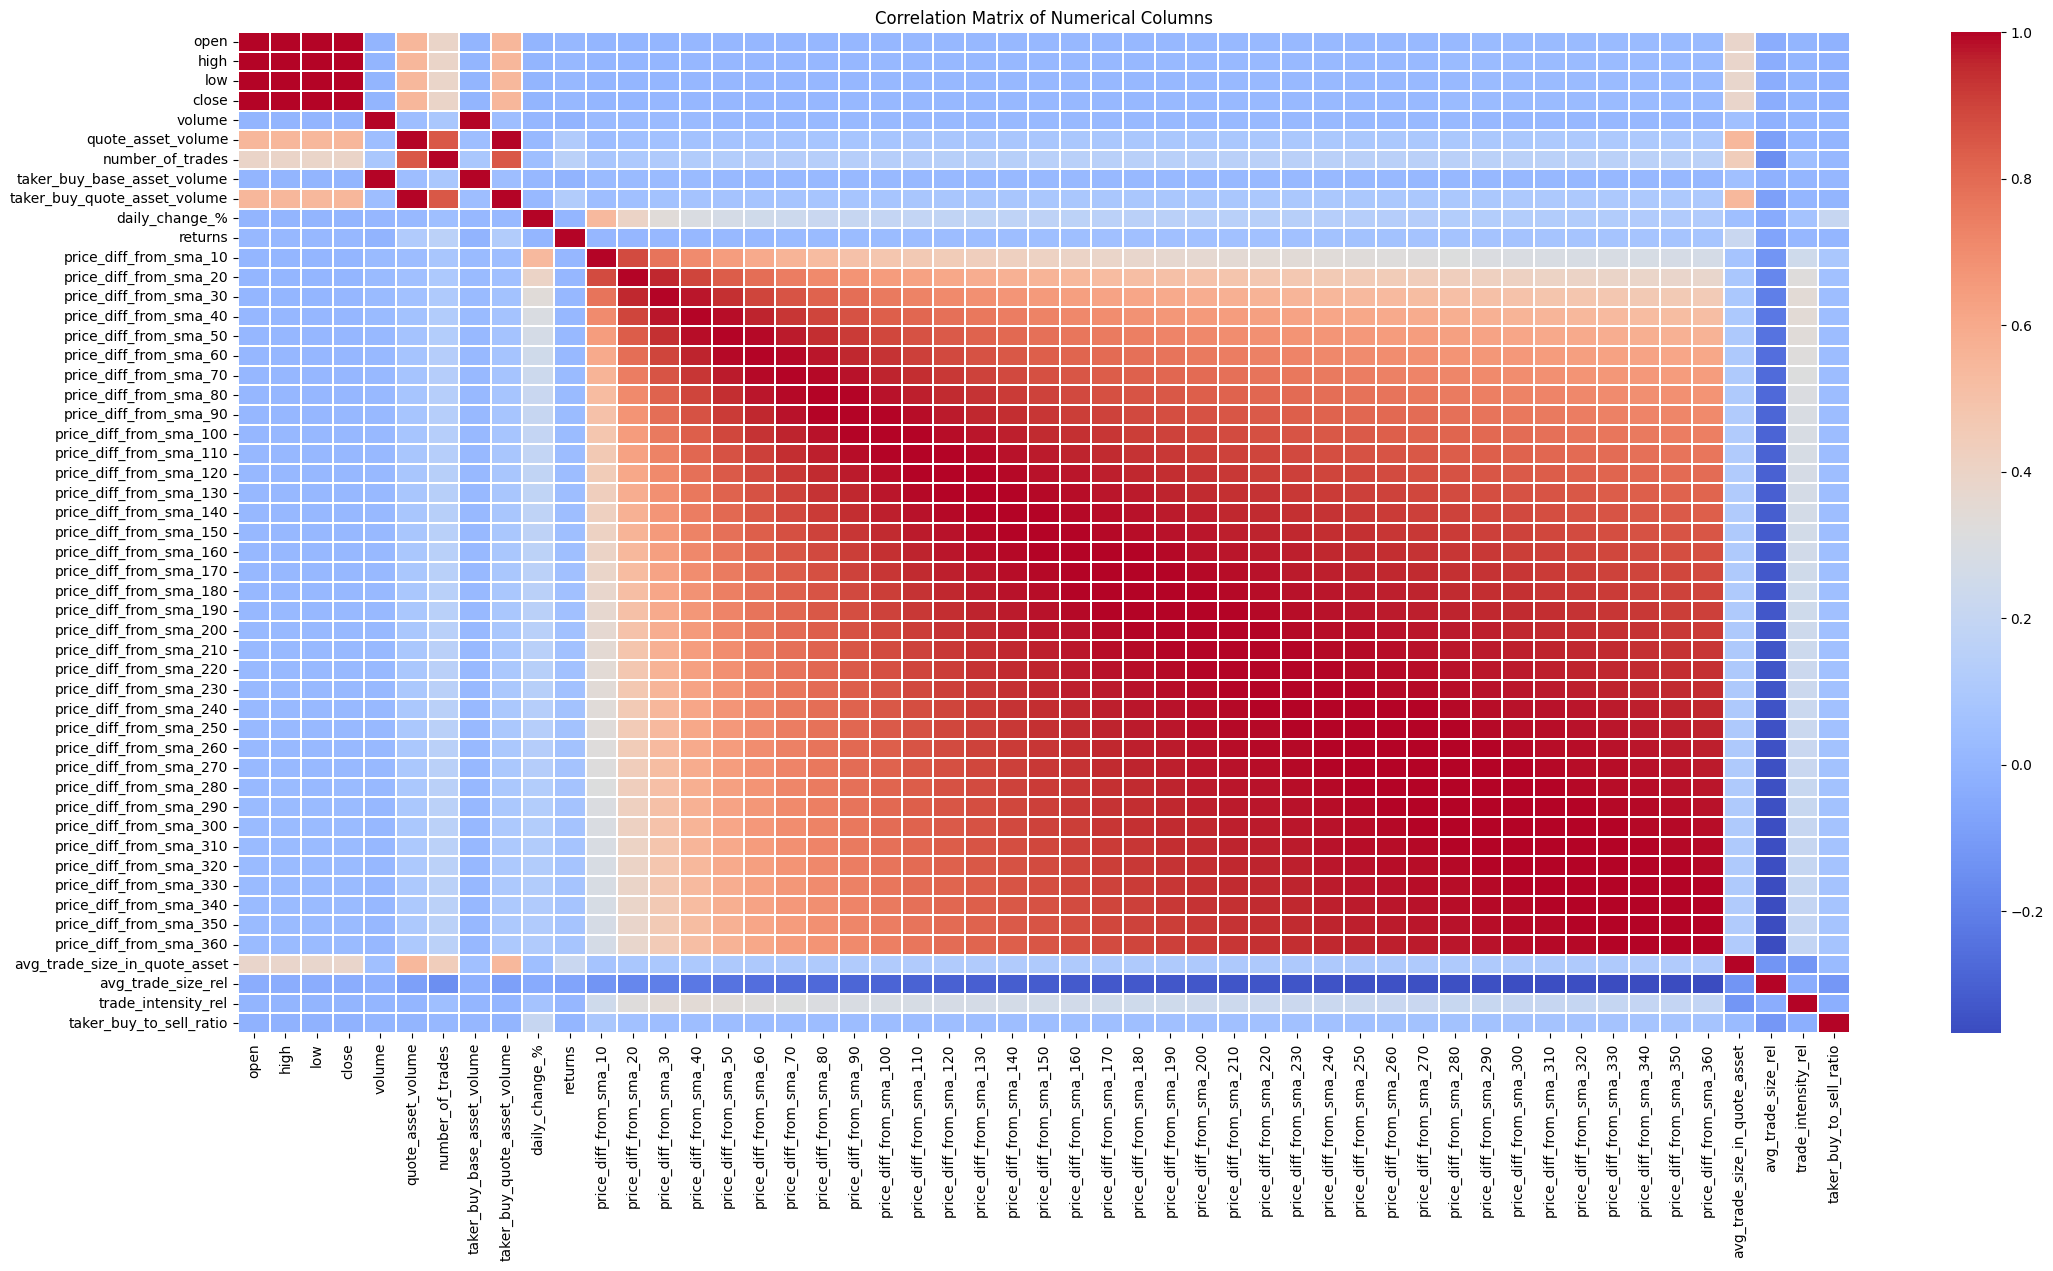

In [19]:
# Identify numericacl columns
numerical_columns = data_with_indicators.columns[2:]

# Correlation analysis between numerical columns
correlation_matrix = data_with_indicators[numerical_columns].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(26, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.2)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [20]:
# Function to define bounds of min and max values in a customized range of time (8, 15, 30 days)
def current_like_state(x: pd.DataFrame, columns: list, period_to_compare: int) -> dict:
    bounds = {"smas_values": {}, "volume_data": {}}
    for col in columns:
        last_values = x[col].iloc[period_to_compare:][::-1]
        lower_bound = last_values.min()
        upper_bound = last_values.max()
        if col.startswith("price_diff"):
            bounds["smas_values"][col] = {"lower": lower_bound, "upper": upper_bound}
        else:
            bounds['volume_data'][col] = {"lower": lower_bound, "upper": upper_bound}
    return bounds

# Function to compare values extracted by "current_like_state" with historical data
def compare_values(x, lower_bound, upper_bound):
    return x if lower_bound <= x <= upper_bound else np.nan

# Assuming the DataFrame 'data_with_indicators' is already defined and processed

# Input from user for symbol and period to compare
symbol_to_compare = str(input("Symbol to compare: ")) 
period_to_compare = int(input("Period from today backwards to compare with historical data (in days): ")) * -1

# Filter the DataFrame for the specific symbol
filtered_data = data_with_indicators[data_with_indicators["pair"] == symbol_to_compare]

# Define the columns to compare
columns_to_compare = [col for col in filtered_data.columns if col.startswith("price_diff")] + [
    "avg_trade_size_in_quote_asset", 
    "avg_trade_size_rel", 
    "trade_intensity_rel", 
    "taker_buy_to_sell_ratio"
]

# Get bounds for the specified symbol
bounds_dict = current_like_state(filtered_data, columns_to_compare, period_to_compare)


# Applying for smas_values
for col, bounds in bounds_dict['smas_values'].items():
    data_with_indicators[f'range_{col}'] = data_with_indicators[col].apply(compare_values, args=(bounds['lower'], bounds['upper']))

# Applying for volume_data
for col, bounds in bounds_dict['volume_data'].items():
    data_with_indicators[f'vol_range_{col}'] = data_with_indicators[col].apply(compare_values, args=(bounds['lower'], bounds['upper']))

# Initialize columns
data_with_indicators['intersection_vol'] = np.nan
data_with_indicators['intersection_sma'] = np.nan
data_with_indicators['intersection_signal'] = np.nan


# Lists to hold column names for intersection
vol_columns_to_intersect_list = []
sma_columns_to_intersect_list = []

# Populate the lists with relevant columns
for col in data_with_indicators.columns:
    if col.startswith("range"):
        sma_columns_to_intersect_list.append(col)
    elif col.startswith("vol_"):
        vol_columns_to_intersect_list.append(col)

level_of_intersection_volume = 1
level_of_intersection_sma = float(input("Level of intersection of SMAs in %: "))

# Create boolean masks for intersections
vol_not_na_mask = data_with_indicators[vol_columns_to_intersect_list].notna()
sma_not_na_mask = data_with_indicators[sma_columns_to_intersect_list].notna()

# Calculate the intersection conditions
vol_intersection_condition = vol_not_na_mask.sum(axis=1) >= (len(vol_columns_to_intersect_list) * level_of_intersection_volume)
sma_intersection_condition = sma_not_na_mask.sum(axis=1) >= (len(sma_columns_to_intersect_list) * (level_of_intersection_sma / 100))
signal_intersection_condition = vol_intersection_condition & sma_intersection_condition


# Apply the intersection conditions
data_with_indicators["intersection_vol"] = np.where(vol_intersection_condition, 1, np.nan)
data_with_indicators["intersection_sma"] = np.where(sma_intersection_condition, 1, np.nan)
data_with_indicators["intersection_signal"] = np.where(signal_intersection_condition, 1, np.nan)

# Check intersections and print results
if data_with_indicators["intersection_vol"].sum() > abs(period_to_compare) and data_with_indicators["intersection_sma"].notna().sum() > abs(period_to_compare):
    print(f"Number of intersected values in df not including compared period: \n" 
          f"Volume intersetions: {(data_with_indicators['intersection_vol'].notna().sum() - abs(period_to_compare))}\n"
          f"SMAs intersections: {(data_with_indicators['intersection_sma'].notna().sum() - abs(period_to_compare))}\n"
          f"Signal intersection: {(data_with_indicators['intersection_signal'].notna().sum() - abs(period_to_compare))}")
else:
    print("No intersections in historical data")

Symbol to compare:  ETHUSDT
Period from today backwards to compare with historical data (in days):  21
Level of intersection of SMAs in %:  90


Number of intersected values in df not including compared period: 
Volume intersetions: 5875
SMAs intersections: 5021
Signal intersection: 183


In [21]:
data_with_indicators[data_with_indicators['intersection_signal'].notna()]["pair"].unique()

array(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT', 'ETCUSDT',
       'FTMUSDT', 'DOGEUSDT', 'KAVAUSDT', 'EURUSDT', 'SOLUSDT',
       'AVAXUSDT'], dtype=object)

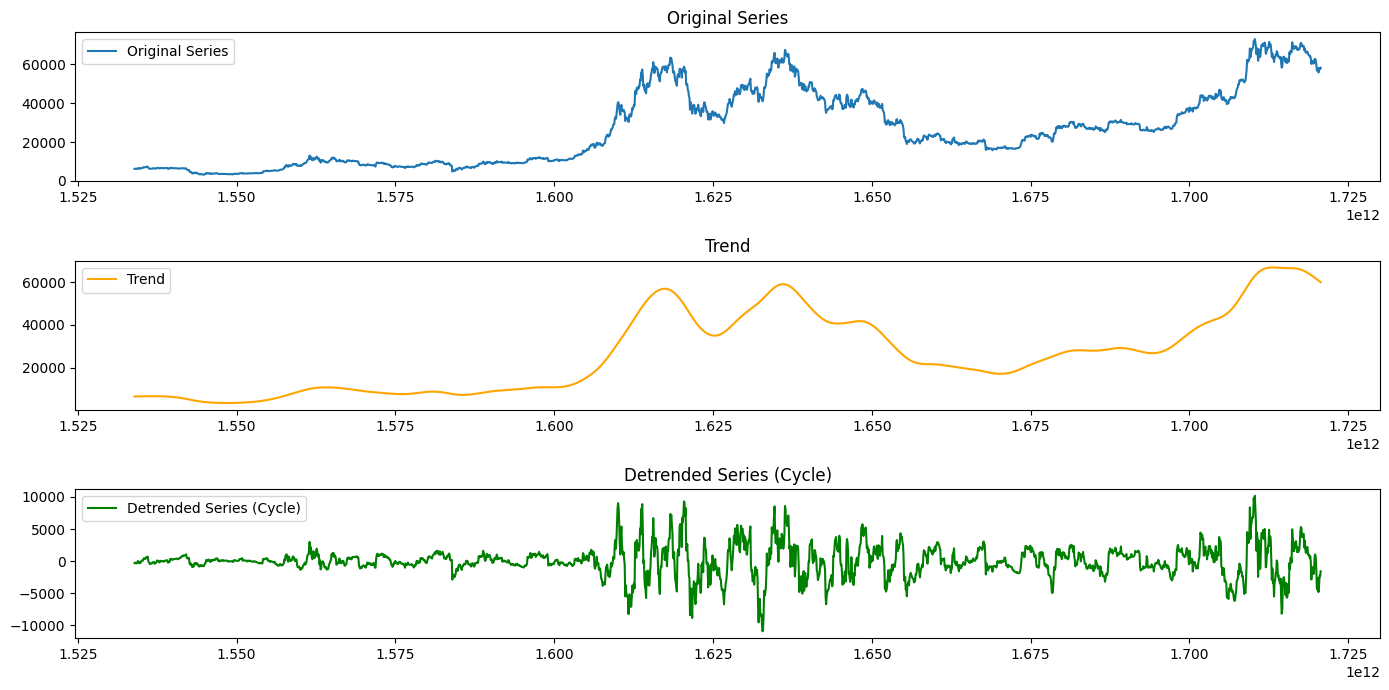

In [127]:
# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(1)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

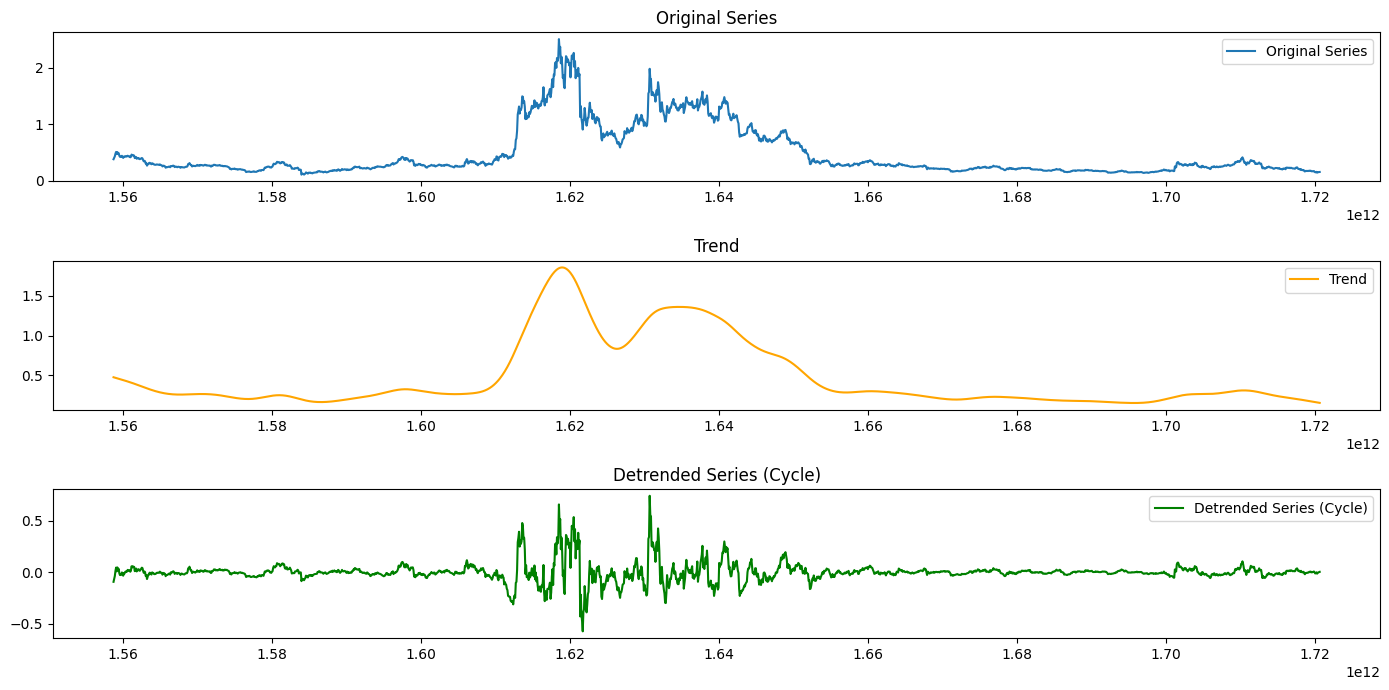

In [128]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(11)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

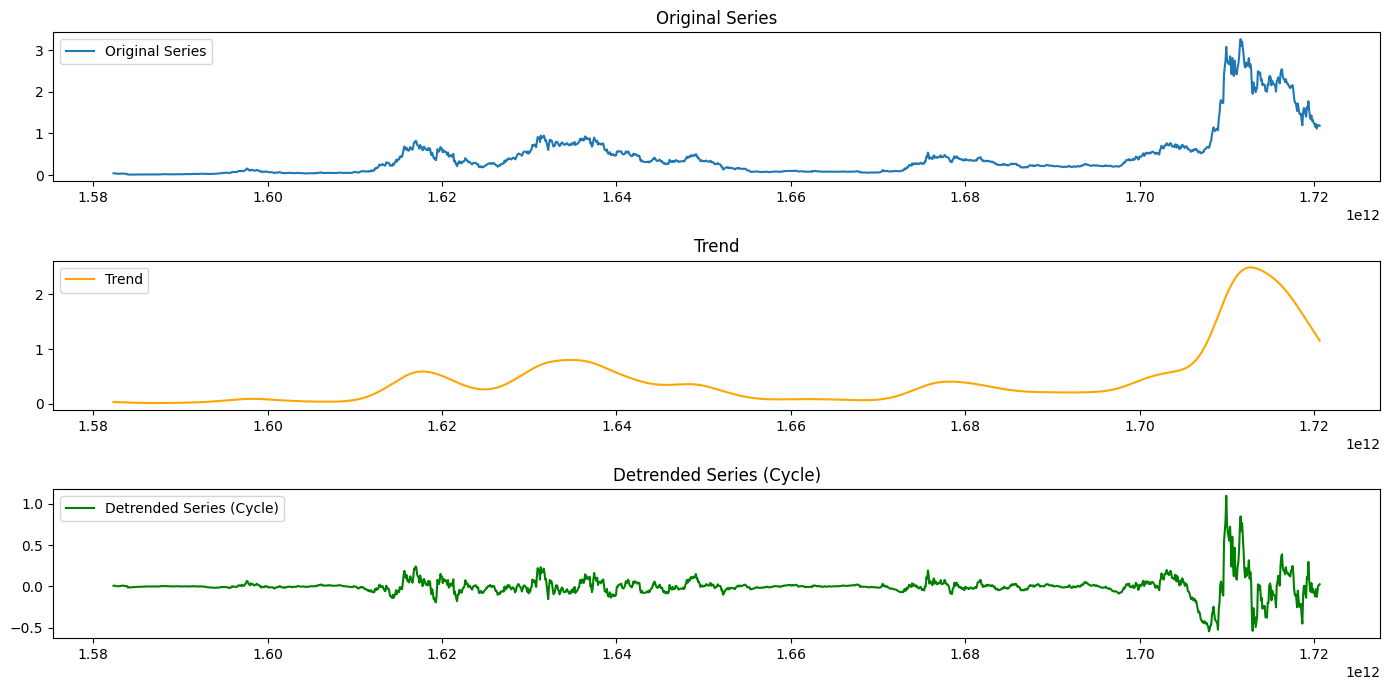

In [129]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(25)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

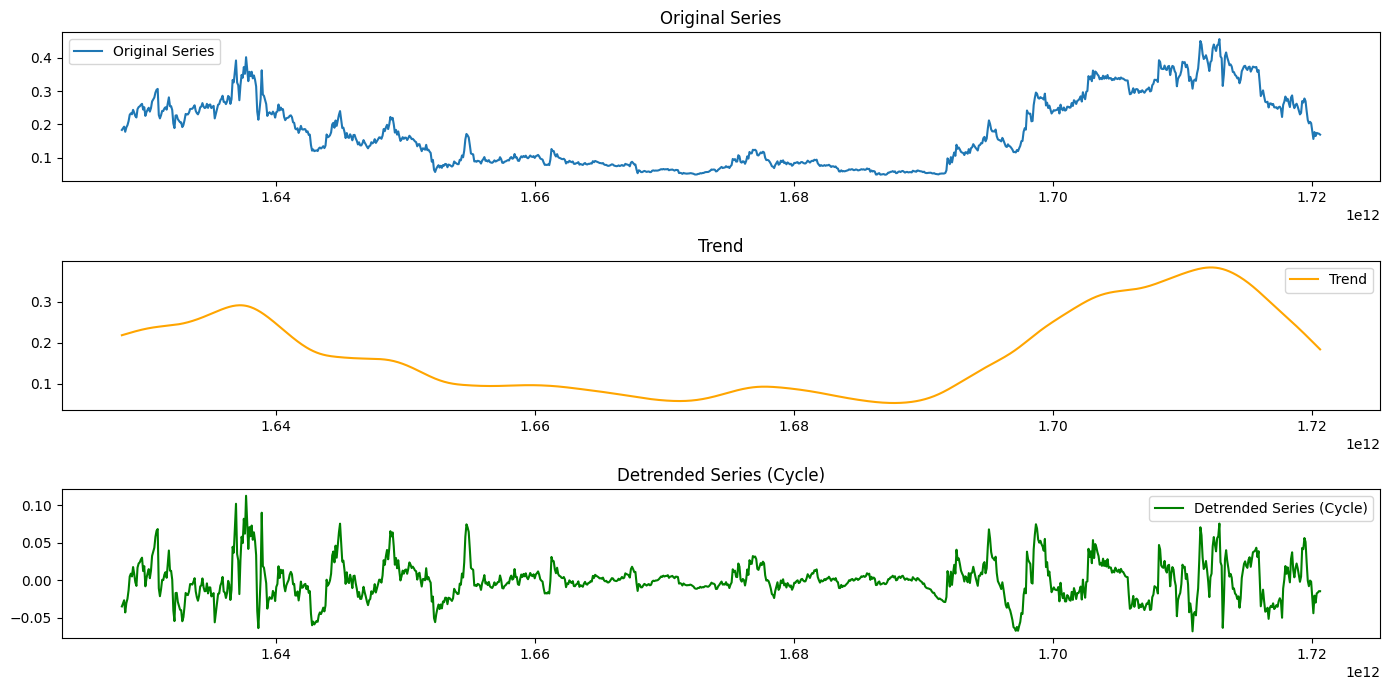

In [130]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(100)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

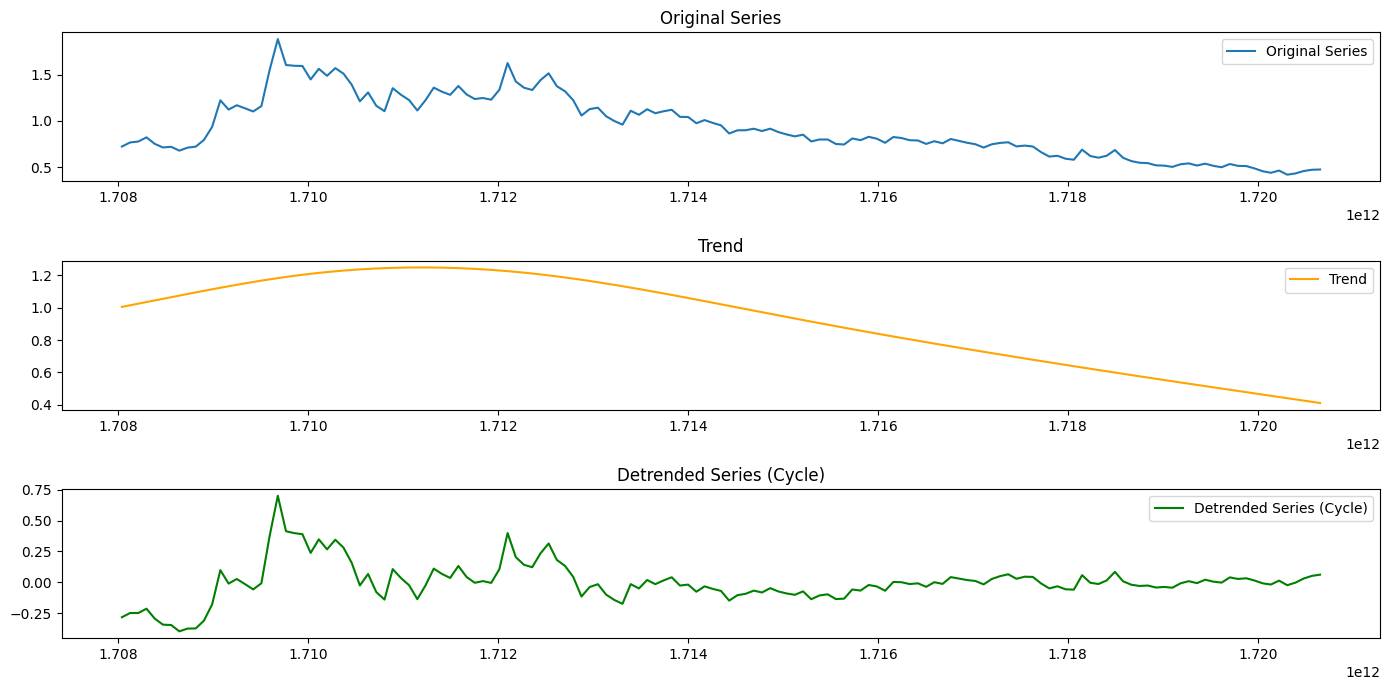

In [134]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(300)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()